In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

**What is a Gated Recurrent Unit (GRU)?**
- A `Gated Recurrent Unit` `(GRU)` is a type of Recurrent Neural Network (RNN) that solves the vanishing gradient problem. It's a simpler and more computationally efficient alternative to the Long Short-Term Memory (LSTM) network. The GRU achieves this by using only two gates: the reset gate and the update gate.

- Reset Gate (r_t): Controls how much of the previous hidden state should be forgotten.

- Update Gate (z_t): Determines how much of the previous hidden state should be carried over to the current hidden state.

- A Simple GRU Example: Time Series Prediction:

This example will demonstrate how a GRU can be used for a simple time series prediction task.

In [3]:
# Generate synthetic time series data
def generate_time_series_data(num_samples, seq_length):
   x = np.linspace(0, 10, num_samples)
   y = np.sin(x) + np.random.normal(0, 0.1, num_samples)

   X, Y= [], []
   for i in range(len(y) - seq_length):
     X.append(y[i:i+seq_length])
     Y.append(y[i+seq_length])

   return np.array(X), np.array(Y)


In [4]:
# parameters
seq_length = 10
num_samples = 200

# Prepare the data
X_raw, Y_raw = generate_time_series_data(num_samples, seq_length)

X_raw


array([[ 0.02055733, -0.23465969,  0.20114594, ...,  0.3541026 ,
         0.49434035,  0.39088295],
       [-0.23465969,  0.20114594, -0.07940387, ...,  0.49434035,
         0.39088295,  0.46125388],
       [ 0.20114594, -0.07940387,  0.04782869, ...,  0.39088295,
         0.46125388,  0.44504677],
       ...,
       [-0.00479067, -0.18420033, -0.08801417, ..., -0.13700687,
        -0.47735578, -0.39745638],
       [-0.18420033, -0.08801417,  0.00611364, ..., -0.47735578,
        -0.39745638, -0.56636645],
       [-0.08801417,  0.00611364, -0.11239996, ..., -0.39745638,
        -0.56636645, -0.46615297]])

In [5]:
# Split Train/Test
X_reshaped = X_raw.reshape(X_raw.shape[0], X_raw.shape[1], 1)

train_size = int(0.8 * len(X_reshaped))
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
Y_train, Y_test = Y_raw[:train_size], Y_raw[train_size:]

In [6]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (152, 10, 1)
Testing data shape: (38, 10, 1)


## GRU (Gated Recurrent Unit) Cell Architecture

![GRU Cell Architecture](TheArchitecture-of-the-gated-recurrent-unit-GRU-cell.png)

The GRU cell is a simplified variant of the LSTM cell, designed to address vanishing gradient problems and improve sequence modeling efficiency.

### Main Components

- **Reset gate (\( r_t \))**: Decides how much of the past hidden state (\( h_{t-1} \)) to forget before combining with the current input (\( x_t \)).
- **Update gate (\( z_t \))**: Controls the extent to which the previous hidden state is carried forward to the next time step.
- **Candidate hidden state (\( \hat{h}_t \))**: Generated from the current input and reset-modified hidden state, using the tanh activation function.
- **Final hidden state (\( h_t \))**: A blend of the previous hidden state and the candidate, controlled by the update gate.

### GRU Equations

\[
\begin{align*}
r_t &= \sigma(W_r [h_{t-1}, x_t]) \\
z_t &= \sigma(W_z [h_{t-1}, x_t]) \\
\hat{h}_t &= \tanh(W [r_t * h_{t-1}, x_t]) \\
h_t &= (1 - z_t) * h_{t-1} + z_t * \hat{h}_t
\end{align*}
\]

Where:
- $\sigma$ is the sigmoid activation function,
- $ [h_{t-1}, x_t] $ denotes concatenation of previous hidden state and current input.

The GRU cell’s gating mechanism allows it to retain useful information for long sequences and update its hidden state effectively.


# Build the GRU Model

In [7]:
model = Sequential()
model.add(GRU(units=50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(units=1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.2851 - val_loss: 0.2999
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1666 - val_loss: 0.1056
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0795 - val_loss: 0.0231
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0326 - val_loss: 0.0186
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0327 - val_loss: 0.0261
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0368 - val_loss: 0.0174
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0289 - val_loss: 0.0150
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0256 - val_loss: 0.0166
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0258 - val_loss: 0.0189
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0255 - val_loss: 0.0176
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0236 - val_loss: 0.0160
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0232 - val_loss: 0.0153


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step


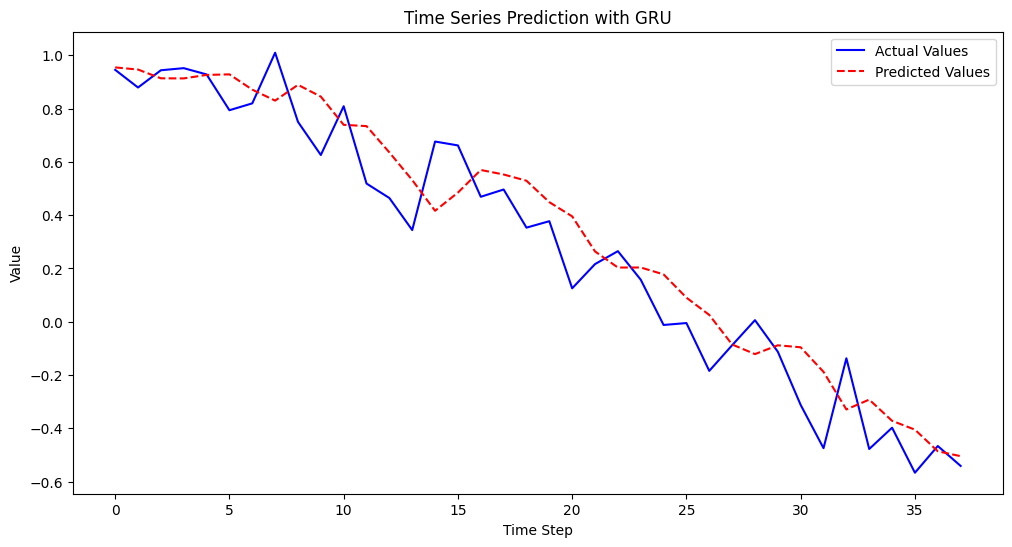

In [10]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red', linestyle='dashed')
plt.title('Time Series Prediction with GRU')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()